# Outtakes

##### [helper function] store edges and costs

In [ ]:
def store_edges_costs_merged(folder_path, edges_costs, name):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    edges_costs_file = os.path.join(folder_path, f'edges_attributes_costs_merged_{name}.csv')
    
    with open(edges_costs_file, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        writer.writerow(["Node1", "Node2", "edgelength", "Build5m", "Maintain5m", 
                        "Build10m", "Maintain10m", "Upgrade"])

        # Write each edge's data
        for node1, node2, attributes in edges_costs:
            writer.writerow([node1, node2, 
                     round(attributes.get('edgelength'),3),
                     #round(attributes.get('slope'),1), 
                     round(attributes.get('Build5m', 0), 2), 
                     round(attributes.get('Maintain5m', 0), 2), 
                     round(attributes.get('Build10m', 0), 2), 
                     round(attributes.get('Maintain10m', 0), 2), 
                     round(attributes.get('Upgrade', 0), 2)])

##### 1.4 take out [helper function] Merge double edges to deal with shared boundaries

In [ ]:
# maybe outtake
def merge_double_edges(edges, edge_attributes):
    road_segments = []
    road_attributes = []

    # Create a dictionary to group edges
    grouped_edges = defaultdict(list)
    for edge, attributes in zip(edges, edge_attributes):
        normalized_edge = tuple(sorted(edge))  # Normalize edge order
        grouped_edges[normalized_edge].append(attributes)

    # Merge attributes for each road segment
    for edge, attributes_list in grouped_edges.items():
        # verage the attributes
        avg_length = sum(attr['edgelength'] for attr in attributes_list) / len(attributes_list)
        avg_slope = sum(attr['slope'] for attr in attributes_list) / len(attributes_list)

        road_segments.append(edge)
        road_attributes.append({'edgelength': avg_length, 'slope': avg_slope})

    return road_segments, road_attributes


## Workflow for Step 1 - 3

In [ ]:
### WORKFLOW ###

for name, df in components.items():
    print(f"Processing component: {name}")

    # Create output folder for the component
    component_folder = f"{out_directory}/{name}"
    os.makedirs(component_folder, exist_ok=True)

    # Extract graph-related data
    vertices, edges, attributes, exit_points = extract_boundaries_with_attributes(df)

    # Save extracted data
    store_data_for_graph(component_folder, vertices, edges, attributes, name)

    # Create and visualize the graph
    G = create_graph(vertices, edges, attributes)
    plot_and_save(G, name, filename=f'{component_folder}/graph_{name}.png')

    # Process and integrate exit points
    contained_count, to_add_count = handle_exit_points(G, exit_points)
    print(f"{contained_count} exit points already exist")
    print(f"{to_add_count} exit points added")

    # Replot and save the updated graph with exit points
    plot_and_save(G, name, filename=f'{component_folder}/1withexit_graph_{name}.png')

    # store the nodes with attributes and edges with attributes again now
    store_updated_graph_data(component_folder, G, name, prefix='1withexit')
    
    print(f"Component summary saved: 'info_{name}.txt'")

Processing component: component_1
Exit node (-20855.407, 152286.946) is already part of the edge ((-20838.0936, 152283.6884), (-20855.407, 152286.946)). Marking it with 'has_exit'.
6 exit points already exist
12 exit points added
Updated graph data saved in: 1_Preprocessed_Data\Road_Network_Graphs/component_1
Component summary saved: 'info_component_1.txt'
Processing component: component_10
2 exit points already exist
2 exit points added
Updated graph data saved in: 1_Preprocessed_Data\Road_Network_Graphs/component_10
Component summary saved: 'info_component_10.txt'
Processing component: component_11
1 exit points already exist
1 exit points added
Updated graph data saved in: 1_Preprocessed_Data\Road_Network_Graphs/component_11
Component summary saved: 'info_component_11.txt'
Processing component: component_12
7 exit points already exist
8 exit points added
Updated graph data saved in: 1_Preprocessed_Data\Road_Network_Graphs/component_12
Component summary saved: 'info_component_12.txt'

## 3. Create road network for the exemplary component

### 3.1 boundaries - extract the boundaries from all stands in that segment

<AxesSubplot: >

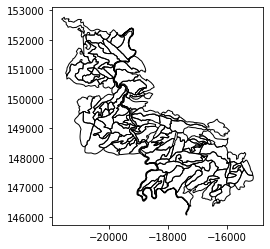

In [ ]:
segment_gdf.plot(facecolor="none")

<AxesSubplot: >

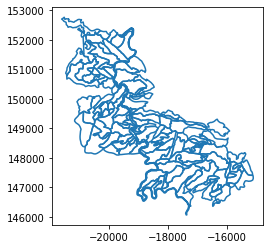

In [ ]:
# Extract boundaries of stands
boundaries = segment_gdf.boundary
boundaries.plot()

#### future roads gdf vllt unnötig

133

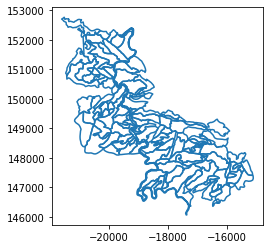

In [ ]:
# Create a GeoDataFrame for the road network from stand boundaries
future_roads = gpd.GeoDataFrame(geometry=boundaries, crs=segment_gdf.crs)
future_roads.plot()
len(future_roads)

In [ ]:
# Check the geometry types in the roads GeoDataFrame
geometry_types = future_roads.geom_type

# Print unique geometry types
print(geometry_types.unique())

['LineString']


133

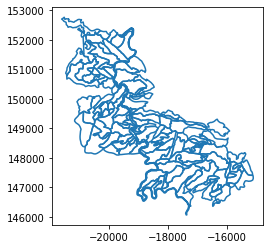

In [ ]:
# Remove duplicate LineStrings (shared boundaries between parcels)
future_roads['sorted_coords'] = future_roads.geometry.apply(lambda x: tuple(sorted(x.coords)))
future_roads = future_roads.drop_duplicates(subset='sorted_coords').drop(columns='sorted_coords')
future_roads.plot()
len(future_roads)

In [ ]:
# Save the boundaries
future_roads.to_file(f'{savepath}/boundaries.gpkg', driver='GPKG')

133

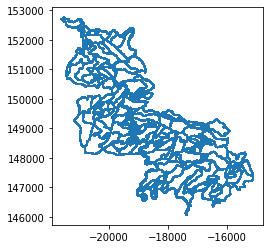

In [ ]:
# Merge touching roads into single geometries
future_roads['geometry'] = future_roads.geometry.unary_union
future_roads.plot()
len(future_roads)

### 3.2 exit points - identify exit points
Around the inaccessible component we have the ring of accessible neighbors.

Thus we can identify the possible *exit points* for the future road segment in this segment now.

1. big roads exit points
2. small roads exit points

In [ ]:
segment_gdf.crs == bigroads_gdf.crs

True

In [ ]:
# Remove invalid or empty geometries
segment_gdf = segment_gdf[segment_gdf.is_valid & ~segment_gdf.is_empty]
bigroads_gdf = bigroads_gdf[bigroads_gdf.is_valid & ~bigroads_gdf.is_empty]

In [ ]:
def identify_exit_points(segment_gdf, bigroads_gdf):

    # Get the boundaries of each forest stand
    segment_gdf["boundary"] = segment_gdf.geometry.boundary
    single_points = 0
    multi_points = 0

    # Find intersections between boundaries and roads
    bigexit_points = []
    for _, stand in segment_gdf.iterrows():
        for _, road in bigroads_gdf.iterrows():
            intersection = stand.boundary.intersection(road.geometry)
            
            # If the intersection is a Point or MultiPoint, store it
            if intersection.geom_type == "Point":
                bigexit_points.append(intersection)
                single_points +=1
            elif intersection.geom_type == "MultiPoint":
                bigexit_points.extend(list(intersection.geoms))
                multi_points += len(list(intersection.geoms))

    # Create a GeoDataFrame with the exit points
    gdf_bigexit_points = gpd.GeoDataFrame(geometry=bigexit_points, crs=segment_gdf.crs)

    total_bigexitpoints = len(gdf_bigexit_points)
    print('total big exit points: ',total_bigexitpoints)
    print('single points: ',single_points)
    print('points in multi points: ',multi_points)

    return gdf_bigexit_points

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


total big exit points:  104
single points:  10
points in multi points:  94


<AxesSubplot: >

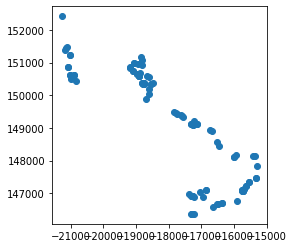

In [ ]:
gdf_bigexit_points = identify_exit_points(segment_gdf, bigroads_gdf)
gdf_bigexit_points.plot()

In [ ]:
# Verify
# Calculate the minimum distance between each exit point and each stand boundary
exit_point_min_distances = []

for _, exit_point in gdf_bigexit_points.iterrows():
    min_distance = float('inf')  # Start with a very large value
    for _, stand in segment_gdf.iterrows():
        stand_boundary = stand.geometry.boundary
        distance = stand_boundary.distance(exit_point.geometry)
        min_distance = min(min_distance, distance)  # Keep track of the minimum distance
    exit_point_min_distances.append(min_distance)

# Find the maximum of the minimum distances
max_of_min_distances = max(exit_point_min_distances)

print(f"Maximum of the minimum distances: {max_of_min_distances}")

Maximum of the minimum distances: 1.4315096654914427e-11


### 3.4 graph - create graph from boundary coordinates
Extract the Stand Boundaries as a Graph

Convert the polygon boundaries into edges in a networkx graph.
The vertices (nodes) of this graph are the endpoints of the boundary segments.

In [ ]:
def create_graph_from_boundaries(boundaries):
    G = nx.Graph()

    # Iterate through each boundary (LineString)
    for idx, boundary in enumerate(boundaries):  
        if isinstance(boundary, LineString):
            coords = list(boundary.coords)  # Extract the coordinates
            declive_value = segment_gdf.iloc[idx]["Declive"]  # Get the single slope value for this boundary

            # Add edges between consecutive points, with attributes
            for i in range(len(coords) - 1):
                node1, node2 = coords[i], coords[i + 1]

                length = LineString([node1, node2]).length

                G.add_edge(node1, node2, length = length, slope = declive_value) 
                
    return G

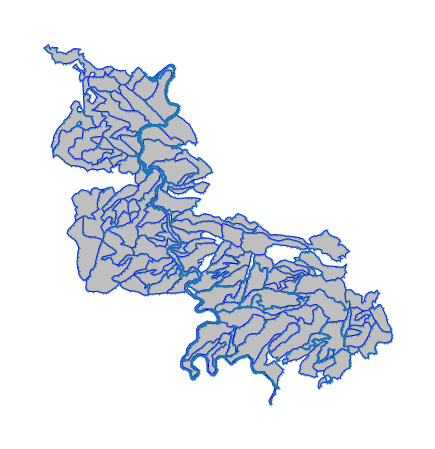

In [ ]:
G = create_graph_from_boundaries(boundaries= segment_gdf.boundary)

# Plot the network
fig, ax = plt.subplots(figsize=(8, 8))
segment_gdf.plot(ax=ax, edgecolor="gray", alpha=0.5, color='gray')  # Plot the original geometries
nx.draw(G, pos={n: n for n in G.nodes()}, node_size=1, edge_color="blue", ax=ax)
plt.show()

#### 3.5 snap exit points

In [ ]:
for exit_point in gdf_bigexit_points.geometry:
    exit_coords = (exit_point.x, exit_point.y)

    # Find the nearest edge (line segment) in the graph
    nearest_edge = None
    min_distance = float("inf")
    
    for u, v, data in G.edges(data=True):
        edge_geom = LineString([u, v])
        dist = exit_point.distance(edge_geom)
        
        if dist < min_distance:
            min_distance = dist
            nearest_edge = (u, v, data, edge_geom)

    if nearest_edge:
        u, v, data, edge_geom = nearest_edge
        
        # Snap exit to the nearest position on the edge
        snapped_exit, _ = nearest_points(exit_point, edge_geom)
        snapped_coords = (snapped_exit.x, snapped_exit.y)

        # Remove the original edge (u, v)
        G.remove_edge(u, v)

        # Compute new segment lengths
        length_1 = LineString([u, snapped_coords]).length
        length_2 = LineString([snapped_coords, v]).length

        # Reinsert edges with preserved attributes
        G.add_edge(u, snapped_coords, length=length_1, slope=data["slope"])
        G.add_edge(snapped_coords, v, length=length_2, slope=data["slope"])

        # Finally, add the exit node itself
        G.add_node(snapped_coords)



### 3.5 doublecheck that all exit points are nodes in graph
Ensure Exit Points Are Nodes in the Graph

Since exits were identified using "intersects", they may not exactly match boundary vertices.
We should snap them to the nearest boundary vertex OR split the nearest boundary edge at the exit location.

In [ ]:
def include_exitpoints_as_nodes(G, gdf_bigexit_points):
    
    # Debug info: Count the initial number of nodes in the graph
    initial_node_count = len(G.nodes)
    already_present = 0

    # Add exit points to the graph if they're not already present
    for _, exit_row in gdf_bigexit_points.iterrows():
        exit_point = exit_row.geometry
        
        # Skip if the exit point is invalid or empty
        if exit_point.is_empty:
            continue
        
        # Get the coordinates of the exit point
        exit_coords = (exit_point.x, exit_point.y)
        
        # Check if the exit point is already a node in the graph
        if exit_coords not in G.nodes:
            # If not, add it as a node
            G.add_node(exit_coords, type="exit", geometry=exit_point)
        else:
            already_present += 1    

    # Count the nodes again after adding missing exit points
    new_node_count = len(G.nodes)

    # Compare the initial and new node counts
    print(f"Initial number of nodes: {initial_node_count}")
    print(f"New number of nodes after adding exit points: {new_node_count}")
    if new_node_count > initial_node_count:
        print(f"Added {new_node_count - initial_node_count} exit points as nodes.")
    else:
        print("No new exit points were added.")

    print(already_present,' exit nodes were already present in G')
    return (G)

In [ ]:
G_full = include_exitpoints_as_nodes(G, gdf_bigexit_points)

Initial number of nodes: 4753
New number of nodes after adding exit points: 4831
Added 78 exit points as nodes.
26  exit nodes were already present in G


### 3.6 simplify graph - remove irrelevant nodes
with degree 2 that are not exit nodes

In [ ]:
num_nodes = G_full.number_of_nodes()
num_edges = G_full.number_of_edges()

print(f"Total nodes: {num_nodes}")
print(f"Total edges: {num_edges}")

Total nodes: 4831
Total edges: 5315


In [ ]:
from collections import Counter

# Get the degree of all nodes
degree_counts = Counter(dict(G.degree()).values())

# Print the number of nodes for each degree
print("Node Degree Distribution:")
for degree, count in sorted(degree_counts.items()):
    print(f"Degree {degree}: {count} nodes")

Node Degree Distribution:
Degree 0: 78 nodes
Degree 2: 3888 nodes
Degree 3: 619 nodes
Degree 4: 235 nodes
Degree 5: 9 nodes
Degree 6: 2 nodes


In [ ]:
# Detect multiple edges manually
edge_count = {}
for node1, node2 in G.edges():
    edge_pair = tuple(sorted([node1, node2]))  # Sort the nodes to avoid direction-related duplicates
    if edge_pair in edge_count:
        edge_count[edge_pair] += 1
    else:
        edge_count[edge_pair] = 1

# Print nodes that have multiple edges
for edge_pair, count in edge_count.items():
    if count > 1:
        print(f"Multiple edges detected between nodes: {edge_pair} (Count: {count})")


#### simplify

- the problem with nodes removal is when adding the newly merged edge
- the problem when adding arises when between N1 and N2 there is already another edge existing
- Maybe use Multigraph? or how to ensure

In [ ]:
def simplify_graph(G):
    """Removes all nodes with degree 2 and merges edges while adjusting length & slope attributes."""

    G_simplified = G.copy()
    
    # determine the nodes to remove (2-deg nodes) BEFORE starting the loop
    nodes_to_remove = [node for node, degree in G.degree() if degree == 2]
    print("# Degree2 nodes: ", len(nodes_to_remove))

    count_skipped_nodes = 0
    count_removed_nodes = 0
    
    for node in nodes_to_remove:
        neighbors = list(G_simplified.neighbors(node))  # Get neighbors of the node
        
        if len(neighbors) == 2:  # Ensure exactly 2 neighbors
            n1, n2 = neighbors  # Get neighboring nodes
            
            # Retrieve existing edge attributes
            edge1 = G_simplified[n1][node]
            edge2 = G_simplified[node][n2]
            
            # Compute new merged edge attributes
            new_length = abs(edge1["length"]) + abs(edge2["length"])  # Sum lengths
            new_slope = (edge1["slope"] * edge1["length"] + edge2["slope"] * edge2["length"]) / new_length  # Weighted average slope
            
            # debug info
            total_length_pre = sum(data["length"] for _, _, data in G_simplified.edges(data=True))

    	    # check if the node pair has already a connection, if so skip that node
            if G_simplified.has_edge(n1, n2):
                # print(f"Edge already exists between {n1} and {n2}")
                count_skipped_nodes += 1
                continue # DO NOT remove the current node & edges, as we can not create a second edge (n1,n2) in a simple graph

            # Remove the old edges before adding the new merged edge
            G_simplified.remove_edge(n1, node)
            G_simplified.remove_edge(node, n2)

            total_length_postremove = sum(data["length"] for _, _, data in G_simplified.edges(data=True))

            # Add new merged edge
            G_simplified.add_edge(n1, n2, length=new_length, slope=new_slope)

            # Verification
            total_length_postaddmerge = sum(data["length"] for _, _, data in G_simplified.edges(data=True))
            
            # Remove the degree-2 node
            G_simplified.remove_node(node)
            count_removed_nodes += 1
            
            # debugging
            if round(total_length_pre,2) != round(total_length_postaddmerge,2):
                print(f"Total length previous: {total_length_pre:.2f}|", f'post remove edges:{total_length_postremove:.2f}|', f'vs. post add merge: {total_length_postaddmerge:.2f}')
                print(f"Merged edge: ({n1}, {n2}), Length: {new_length}, Slope: {new_slope}")
                print(total_length_pre-total_length_postremove)
                break
    return G_simplified, count_removed_nodes, count_skipped_nodes

In [ ]:
# Simplify the graph
G_simplified, count_removed_nodes, count_skipped_nodes = simplify_graph(G)
print(' # Skipped nodes:', count_skipped_nodes)
print('# Removed nodes.:', count_removed_nodes)

Deg2 Nodes:  3888
Skipped nodes 377
removed nodes 3511


In [ ]:
# Verification
total_pre = sum(data["length"] for _, _, data in G.edges(data=True))
total_post = sum(data["length"] for _, _, data in G_simplified.edges(data=True))
print(f"Total length previous: {total_pre:.2f}", f'vs. Total length post: {total_post:.2f}')

# Print number of nodes & edges before and after
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Simplified Graph: {G_simplified.number_of_nodes()} nodes, {G_simplified.number_of_edges()} edges")

Total length previous: 186074.37 vs. Total length post: 186074.37
Original Graph: 4753 nodes, 5315 edges
Simplified Graph: 1242 nodes, 1804 edges


#### Visual representation of simplified graph
Attention: Now this graph is simplified representation of the boundaries. It still contains the same length and slope information, but does not accurately represent the geodata as accurate as before anymore, see image below:

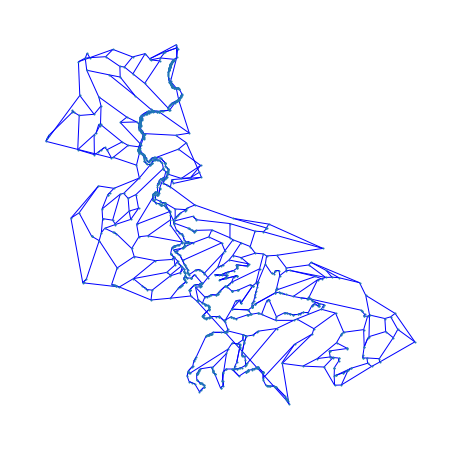

In [ ]:
# Plot the network
fig, ax = plt.subplots(figsize=(8, 8))
#segment_gdf.plot(ax=ax, edgecolor="gray", alpha=0.5)  # Plot the original geometries
nx.draw(G_simplified, pos={n: n for n in G_simplified.nodes()}, node_size=1, edge_color="blue", ax=ax)

plt.show()

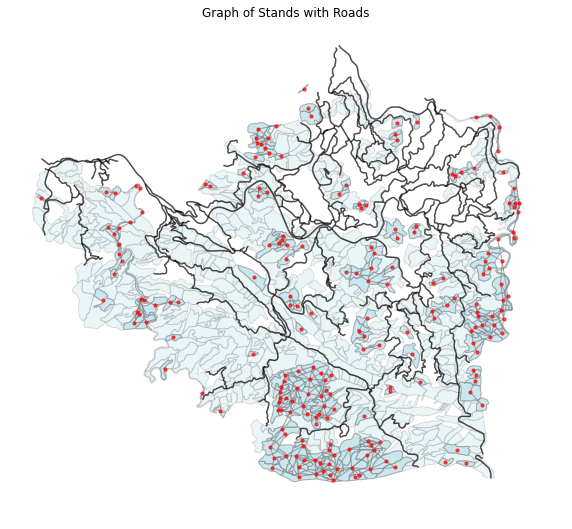

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries of the stands
stands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.5)

# Plot the roads (assuming roads_gdf is your GeoDataFrame with road data)
bigroads_gdf.plot(ax=ax, color='black', alpha=0.7)

# Plot the other stands
allstands_gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.25)

# Get node positions based on the centroid of each stand geometry
pos = {node: (stand['geometry'].centroid.x, stand['geometry'].centroid.y) 
       for node, stand in G.nodes(data=True)}

# Draw the graph nodes and edges
nx.draw(G, pos, ax=ax, with_labels=False, node_size=10, node_color='red', 
        font_size=8, font_color='black', alpha=0.7, edge_color='gray')

# Add a title to the plot
plt.title("Graph of Stands with Roads")

# Save and show the plot
plt.savefig(f"{out_path}/graph_of_touching_stands_with_roads.png")
plt.show()


## 3. Create road network for the exemplary component

### 3.1 boundaries - extract the boundaries from all stands in that segment

<AxesSubplot: >

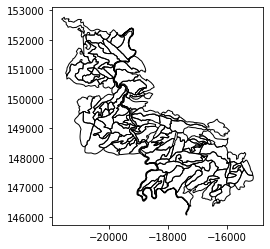

In [ ]:
segment_gdf.plot(facecolor="none")

<AxesSubplot: >

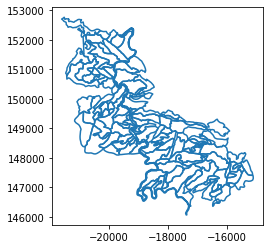

In [ ]:
# Extract boundaries of stands
boundaries = segment_gdf.boundary
boundaries.plot()

#### future roads gdf vllt unnötig

133

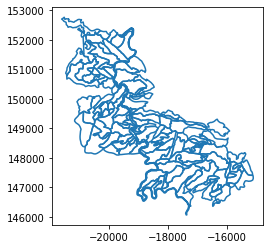

In [ ]:
# Create a GeoDataFrame for the road network from stand boundaries
future_roads = gpd.GeoDataFrame(geometry=boundaries, crs=segment_gdf.crs)
future_roads.plot()
len(future_roads)

In [ ]:
# Check the geometry types in the roads GeoDataFrame
geometry_types = future_roads.geom_type

# Print unique geometry types
print(geometry_types.unique())

['LineString']


133

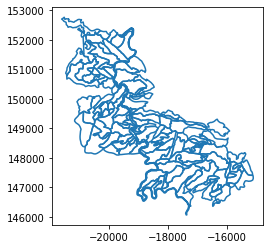

In [ ]:
# Remove duplicate LineStrings (shared boundaries between parcels)
future_roads['sorted_coords'] = future_roads.geometry.apply(lambda x: tuple(sorted(x.coords)))
future_roads = future_roads.drop_duplicates(subset='sorted_coords').drop(columns='sorted_coords')
future_roads.plot()
len(future_roads)

In [ ]:
# Save the boundaries
future_roads.to_file(f'{savepath}/boundaries.gpkg', driver='GPKG')

133

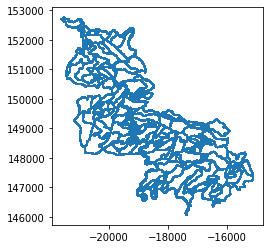

In [ ]:
# Merge touching roads into single geometries
future_roads['geometry'] = future_roads.geometry.unary_union
future_roads.plot()
len(future_roads)

### 3.2 exit points - identify exit points
Around the inaccessible component we have the ring of accessible neighbors.

Thus we can identify the possible *exit points* for the future road segment in this segment now.

1. big roads exit points
2. small roads exit points

In [ ]:
segment_gdf.crs == bigroads_gdf.crs

True

In [ ]:
# Remove invalid or empty geometries
segment_gdf = segment_gdf[segment_gdf.is_valid & ~segment_gdf.is_empty]
bigroads_gdf = bigroads_gdf[bigroads_gdf.is_valid & ~bigroads_gdf.is_empty]

In [ ]:
def identify_exit_points(segment_gdf, bigroads_gdf):

    # Get the boundaries of each forest stand
    segment_gdf["boundary"] = segment_gdf.geometry.boundary
    single_points = 0
    multi_points = 0

    # Find intersections between boundaries and roads
    bigexit_points = []
    for _, stand in segment_gdf.iterrows():
        for _, road in bigroads_gdf.iterrows():
            intersection = stand.boundary.intersection(road.geometry)
            
            # If the intersection is a Point or MultiPoint, store it
            if intersection.geom_type == "Point":
                bigexit_points.append(intersection)
                single_points +=1
            elif intersection.geom_type == "MultiPoint":
                bigexit_points.extend(list(intersection.geoms))
                multi_points += len(list(intersection.geoms))

    # Create a GeoDataFrame with the exit points
    gdf_bigexit_points = gpd.GeoDataFrame(geometry=bigexit_points, crs=segment_gdf.crs)

    total_bigexitpoints = len(gdf_bigexit_points)
    print('total big exit points: ',total_bigexitpoints)
    print('single points: ',single_points)
    print('points in multi points: ',multi_points)

    return gdf_bigexit_points

c:\Users\johan\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


total big exit points:  104
single points:  10
points in multi points:  94


<AxesSubplot: >

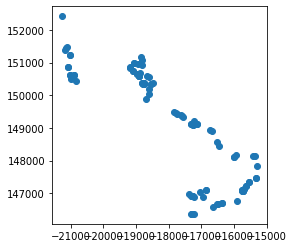

In [ ]:
gdf_bigexit_points = identify_exit_points(segment_gdf, bigroads_gdf)
gdf_bigexit_points.plot()

In [ ]:
# Verify
# Calculate the minimum distance between each exit point and each stand boundary
exit_point_min_distances = []

for _, exit_point in gdf_bigexit_points.iterrows():
    min_distance = float('inf')  # Start with a very large value
    for _, stand in segment_gdf.iterrows():
        stand_boundary = stand.geometry.boundary
        distance = stand_boundary.distance(exit_point.geometry)
        min_distance = min(min_distance, distance)  # Keep track of the minimum distance
    exit_point_min_distances.append(min_distance)

# Find the maximum of the minimum distances
max_of_min_distances = max(exit_point_min_distances)

print(f"Maximum of the minimum distances: {max_of_min_distances}")

Maximum of the minimum distances: 1.4315096654914427e-11


### 3.4 graph - create graph from boundary coordinates
Extract the Stand Boundaries as a Graph

Convert the polygon boundaries into edges in a networkx graph.
The vertices (nodes) of this graph are the endpoints of the boundary segments.

In [ ]:
def create_graph_from_boundaries(boundaries):
    G = nx.Graph()

    # Iterate through each boundary (LineString)
    for idx, boundary in enumerate(boundaries):  
        if isinstance(boundary, LineString):
            coords = list(boundary.coords)  # Extract the coordinates
            declive_value = segment_gdf.iloc[idx]["Declive"]  # Get the single slope value for this boundary

            # Add edges between consecutive points, with attributes
            for i in range(len(coords) - 1):
                node1, node2 = coords[i], coords[i + 1]

                length = LineString([node1, node2]).length

                G.add_edge(node1, node2, length = length, slope = declive_value) 
                
    return G

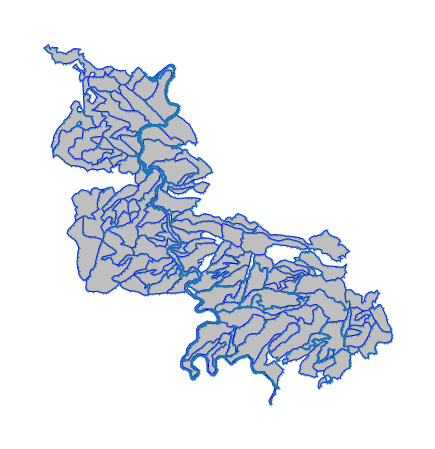

In [ ]:
G = create_graph_from_boundaries(boundaries= segment_gdf.boundary)

# Plot the network
fig, ax = plt.subplots(figsize=(8, 8))
segment_gdf.plot(ax=ax, edgecolor="gray", alpha=0.5, color='gray')  # Plot the original geometries
nx.draw(G, pos={n: n for n in G.nodes()}, node_size=1, edge_color="blue", ax=ax)
plt.show()

#### 3.5 snap exit points

In [ ]:
for exit_point in gdf_bigexit_points.geometry:
    exit_coords = (exit_point.x, exit_point.y)

    # Find the nearest edge (line segment) in the graph
    nearest_edge = None
    min_distance = float("inf")
    
    for u, v, data in G.edges(data=True):
        edge_geom = LineString([u, v])
        dist = exit_point.distance(edge_geom)
        
        if dist < min_distance:
            min_distance = dist
            nearest_edge = (u, v, data, edge_geom)

    if nearest_edge:
        u, v, data, edge_geom = nearest_edge
        
        # Snap exit to the nearest position on the edge
        snapped_exit, _ = nearest_points(exit_point, edge_geom)
        snapped_coords = (snapped_exit.x, snapped_exit.y)

        # Remove the original edge (u, v)
        G.remove_edge(u, v)

        # Compute new segment lengths
        length_1 = LineString([u, snapped_coords]).length
        length_2 = LineString([snapped_coords, v]).length

        # Reinsert edges with preserved attributes
        G.add_edge(u, snapped_coords, length=length_1, slope=data["slope"])
        G.add_edge(snapped_coords, v, length=length_2, slope=data["slope"])

        # Finally, add the exit node itself
        G.add_node(snapped_coords)



### 3.5 doublecheck that all exit points are nodes in graph
Ensure Exit Points Are Nodes in the Graph

Since exits were identified using "intersects", they may not exactly match boundary vertices.
We should snap them to the nearest boundary vertex OR split the nearest boundary edge at the exit location.

In [ ]:
def include_exitpoints_as_nodes(G, gdf_bigexit_points):
    
    # Debug info: Count the initial number of nodes in the graph
    initial_node_count = len(G.nodes)
    already_present = 0

    # Add exit points to the graph if they're not already present
    for _, exit_row in gdf_bigexit_points.iterrows():
        exit_point = exit_row.geometry
        
        # Skip if the exit point is invalid or empty
        if exit_point.is_empty:
            continue
        
        # Get the coordinates of the exit point
        exit_coords = (exit_point.x, exit_point.y)
        
        # Check if the exit point is already a node in the graph
        if exit_coords not in G.nodes:
            # If not, add it as a node
            G.add_node(exit_coords, type="exit", geometry=exit_point)
        else:
            already_present += 1    

    # Count the nodes again after adding missing exit points
    new_node_count = len(G.nodes)

    # Compare the initial and new node counts
    print(f"Initial number of nodes: {initial_node_count}")
    print(f"New number of nodes after adding exit points: {new_node_count}")
    if new_node_count > initial_node_count:
        print(f"Added {new_node_count - initial_node_count} exit points as nodes.")
    else:
        print("No new exit points were added.")

    print(already_present,' exit nodes were already present in G')
    return (G)

In [ ]:
G_full = include_exitpoints_as_nodes(G, gdf_bigexit_points)

Initial number of nodes: 4753
New number of nodes after adding exit points: 4831
Added 78 exit points as nodes.
26  exit nodes were already present in G


### 3.6 simplify graph - remove irrelevant nodes
with degree 2 that are not exit nodes

In [ ]:
num_nodes = G_full.number_of_nodes()
num_edges = G_full.number_of_edges()

print(f"Total nodes: {num_nodes}")
print(f"Total edges: {num_edges}")

Total nodes: 4831
Total edges: 5315


In [ ]:
from collections import Counter

# Get the degree of all nodes
degree_counts = Counter(dict(G.degree()).values())

# Print the number of nodes for each degree
print("Node Degree Distribution:")
for degree, count in sorted(degree_counts.items()):
    print(f"Degree {degree}: {count} nodes")

Node Degree Distribution:
Degree 0: 78 nodes
Degree 2: 3888 nodes
Degree 3: 619 nodes
Degree 4: 235 nodes
Degree 5: 9 nodes
Degree 6: 2 nodes


In [ ]:
# Detect multiple edges manually
edge_count = {}
for node1, node2 in G.edges():
    edge_pair = tuple(sorted([node1, node2]))  # Sort the nodes to avoid direction-related duplicates
    if edge_pair in edge_count:
        edge_count[edge_pair] += 1
    else:
        edge_count[edge_pair] = 1

# Print nodes that have multiple edges
for edge_pair, count in edge_count.items():
    if count > 1:
        print(f"Multiple edges detected between nodes: {edge_pair} (Count: {count})")


#### simplify

- the problem with nodes removal is when adding the newly merged edge
- the problem when adding arises when between N1 and N2 there is already another edge existing
- Maybe use Multigraph? or how to ensure

In [ ]:
def simplify_graph(G):
    """Removes all nodes with degree 2 and merges edges while adjusting length & slope attributes."""

    G_simplified = G.copy()
    
    # determine the nodes to remove (2-deg nodes) BEFORE starting the loop
    nodes_to_remove = [node for node, degree in G.degree() if degree == 2]
    print("# Degree2 nodes: ", len(nodes_to_remove))

    count_skipped_nodes = 0
    count_removed_nodes = 0
    
    for node in nodes_to_remove:
        neighbors = list(G_simplified.neighbors(node))  # Get neighbors of the node
        
        if len(neighbors) == 2:  # Ensure exactly 2 neighbors
            n1, n2 = neighbors  # Get neighboring nodes
            
            # Retrieve existing edge attributes
            edge1 = G_simplified[n1][node]
            edge2 = G_simplified[node][n2]
            
            # Compute new merged edge attributes
            new_length = abs(edge1["length"]) + abs(edge2["length"])  # Sum lengths
            new_slope = (edge1["slope"] * edge1["length"] + edge2["slope"] * edge2["length"]) / new_length  # Weighted average slope
            
            # debug info
            total_length_pre = sum(data["length"] for _, _, data in G_simplified.edges(data=True))

    	    # check if the node pair has already a connection, if so skip that node
            if G_simplified.has_edge(n1, n2):
                # print(f"Edge already exists between {n1} and {n2}")
                count_skipped_nodes += 1
                continue # DO NOT remove the current node & edges, as we can not create a second edge (n1,n2) in a simple graph

            # Remove the old edges before adding the new merged edge
            G_simplified.remove_edge(n1, node)
            G_simplified.remove_edge(node, n2)

            total_length_postremove = sum(data["length"] for _, _, data in G_simplified.edges(data=True))

            # Add new merged edge
            G_simplified.add_edge(n1, n2, length=new_length, slope=new_slope)

            # Verification
            total_length_postaddmerge = sum(data["length"] for _, _, data in G_simplified.edges(data=True))
            
            # Remove the degree-2 node
            G_simplified.remove_node(node)
            count_removed_nodes += 1
            
            # debugging
            if round(total_length_pre,2) != round(total_length_postaddmerge,2):
                print(f"Total length previous: {total_length_pre:.2f}|", f'post remove edges:{total_length_postremove:.2f}|', f'vs. post add merge: {total_length_postaddmerge:.2f}')
                print(f"Merged edge: ({n1}, {n2}), Length: {new_length}, Slope: {new_slope}")
                print(total_length_pre-total_length_postremove)
                break
    return G_simplified, count_removed_nodes, count_skipped_nodes

In [ ]:
# Simplify the graph
G_simplified, count_removed_nodes, count_skipped_nodes = simplify_graph(G)
print(' # Skipped nodes:', count_skipped_nodes)
print('# Removed nodes.:', count_removed_nodes)

Deg2 Nodes:  3888
Skipped nodes 377
removed nodes 3511


In [ ]:
# Verification
total_pre = sum(data["length"] for _, _, data in G.edges(data=True))
total_post = sum(data["length"] for _, _, data in G_simplified.edges(data=True))
print(f"Total length previous: {total_pre:.2f}", f'vs. Total length post: {total_post:.2f}')

# Print number of nodes & edges before and after
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Simplified Graph: {G_simplified.number_of_nodes()} nodes, {G_simplified.number_of_edges()} edges")

Total length previous: 186074.37 vs. Total length post: 186074.37
Original Graph: 4753 nodes, 5315 edges
Simplified Graph: 1242 nodes, 1804 edges


#### Visual representation of simplified graph
Attention: Now this graph is simplified representation of the boundaries. It still contains the same length and slope information, but does not accurately represent the geodata as accurate as before anymore, see image below:

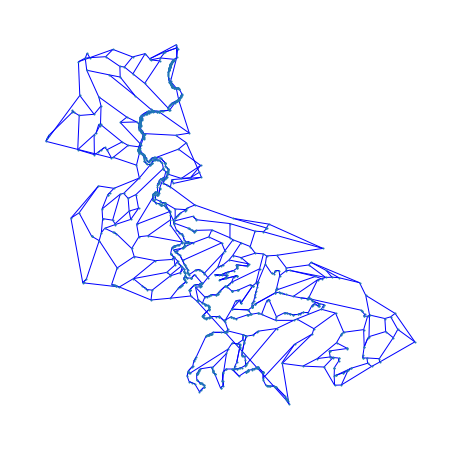

In [ ]:
# Plot the network
fig, ax = plt.subplots(figsize=(8, 8))
#segment_gdf.plot(ax=ax, edgecolor="gray", alpha=0.5)  # Plot the original geometries
nx.draw(G_simplified, pos={n: n for n in G_simplified.nodes()}, node_size=1, edge_color="blue", ax=ax)

plt.show()

#### 3.2.2 incorporate exit points in stands boundaries

### 3.3 include exit points in polygons

In [ ]:
def add_point_to_polygon(gdf_polygons, gdf_points):

    new_gdf_polygons = gdf_polygons.copy()

    # loop through exit points
    for point in gdf_points.geometry: 
        
        # Loop through polygons to find the polygon that contains the point
            for idx, poly in new_gdf_polygons.iterrows():
                polygon = poly['geometry']

            if poly.boundary.contains(point):  # Check if point is part of polygon boundary
                print('polygon contains point')

                # Add point to the polygon's boundary if not already there
                coordsall = list(polygon.exterior.coords)

                if (point.x, point.y) not in coordsall:  # Only add if it's not already in the boundary
                    print('point not in coordinates of polygone boundary yet')
                    # Extract coordinates (excluding the duplicate last coordinate)
                    coords = list(polygon.exterior.coords[:-1])  # Remove duplicate closing point

                    # Find the correct segment to insert the point
                    for i in range(len(coords) - 1):
                        p1, p2 = coords[i], coords[i + 1]
                        
                        # Check if the point is on the edge (collinear with segment p1-p2)
                        if Point(p1).distance(point) + Point(p2).distance(point) == Point(p1).distance(Point(p2)):
                            coords.insert(i + 1, (point.x, point.y))  # Insert at the correct position
                            print('added exit point to boundary')
                            break  # Stop once inserted

                    # Ensure the polygon remains closed
                    coords.append(coords[0])

                    # Create a new polygon with the updated boundary
                    new_polygon = Polygon(coords)
                    new_gdf_polygons.at[idx, 'geometry'] = new_polygon  # Update the polygon in the GeoDataFrame
                    print('polygon updated')
                break
    return new_gdf_polygons

<AxesSubplot: >

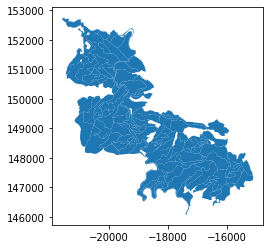

In [ ]:
gdf_polygons_updated = add_point_to_polygon(segment_gdf, gdf_bigexit_points)
gdf_polygons_updated.plot()

In [ ]:
def include_exitpoints_in_polygons(segment_gdf, gdf_exitpoints):
    
    new_segment_gdf = segment_gdf.copy()

    # Ensure gdf_exitpoints only contains unique points
    exitpoints = gdf_exitpoints.geometry.explode().unique()

    # Function to update a polygon by incorporating points
    def adjust_polygon(polygon, points):
        if polygon is None or polygon.is_empty:
            return polygon
        
        # Get existing polygon boundary coordinates
        existing_coords = list(polygon.exterior.coords)
        
        # Add new points explicitly
        new_coords = existing_coords + [(p.x, p.y) for p in points if not p.within(polygon)]
        
        # Create a new polygon, ensuring the first and last points are the same (closed loop)
        new_polygon = Polygon(new_coords).convex_hull  # Convex hull to maintain shape
        return new_polygon

    # Apply the function to each polygon
    new_segment_gdf["geometry"] = segment_gdf.geometry.apply(lambda poly: adjust_polygon(poly, exitpoints))

    # Ensure valid geometries
    new_segment_gdf = new_segment_gdf.set_geometry(segment_gdf.geometry.apply(lambda g: g if g.is_valid else g.buffer(0)))
    
    return new_segment_gdf

In [ ]:
def update_boundaries(segment_gdf, exitpoints_gdf):
    
    segment_with_exit_points = segment_gdf.copy()

    # Loop through each stand and add the exit points to the boundaries
    for i, stand in segment_with_exit_points.iterrows():
        # Get the boundary of the current stand
        current_boundary = stand.geometry.boundary
        
        # Check for intersections with exit points and add them to the boundary
        for exit_point in exitpoints_gdf.geometry:
            if current_boundary.distance(exit_point) < 0.0000001:  # Specify a threshold distance if needed
                current_boundary = current_boundary.union(exit_point)
        
        # Update the boundary geometry in the new GeoDataFrame
        segment_with_exit_points.at[i, 'boundary'] = current_boundary

    print('Exit points incorporated in updated boundaries of segment.')
    return segment_with_exit_points

Exit points incorporated in updated boundaries of segment.


<AxesSubplot: >

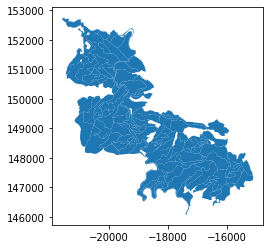

In [ ]:
segment_with_exit_points = update_boundaries(segment_gdf, gdf_bigexit_points)
segment_with_exit_points.plot()

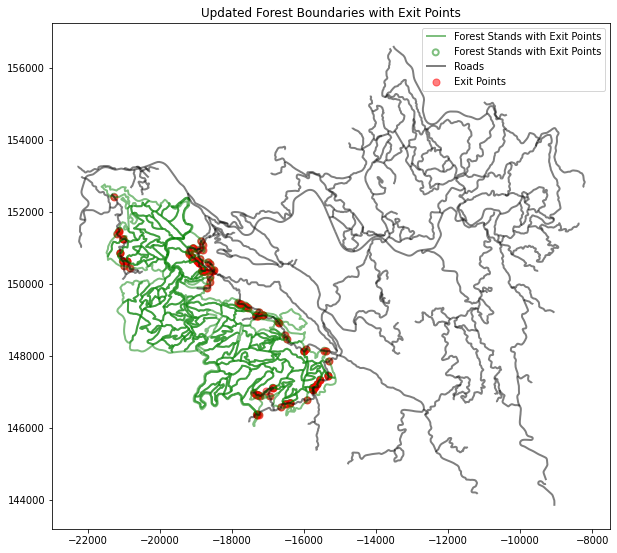

In [ ]:
# Plot the updated segment_gdf with the exit points included
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the updated forest stands (now including exit points)
segment_with_exit_points.plot(ax=ax, edgecolor="green", facecolor="none", linewidth=2, label="Forest Stands with Exit Points", alpha=.5)

# Plot roads
bigroads_gdf.plot(ax=ax, color="black", linewidth=2, label="Roads", alpha=.5)

# Plot the original exit points (in red)
gdf_bigexit_points.plot(ax=ax, color="red", markersize=50, label="Exit Points", alpha=.5)

plt.title("Updated Forest Boundaries with Exit Points")
plt.legend()
plt.show()

In [ ]:
# find stands touching roads
stands_touching_roads = stands[stands.geometry.intersects(roads.unary_union)]
not_touching_roads = stands[~stands['ID_UG'].isin(stands_touching_roads['ID_UG'])]
print("Stands touching roads:")
print(len(stands_touching_roads))
print("Not touching roads:")
print(len(not_touching_roads))

In [ ]:
# Create a plot to visualize the stands touching roads
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
roads.plot(ax=ax, color='black', label='Roads', alpha=0.7)

# Plot stands
stands_touching_roads.plot(ax=ax, color='green', label='Stands', alpha=0.5, edgecolor = 'grey')
not_touching_roads.plot(ax=ax, color='orange', label='Stands', alpha=0.7, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=2, label='Roads', alpha=0.7)  # Line for roads
stand_patch = mpatches.Patch(color='orange', label=f'Stands unaccessible via existing roads: {len(not_touching_roads)}', alpha=0.5)
crossed_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via existing roads: {len(stands_touching_roads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, crossed_stand_patch, stand_patch])
ax.axis('off')
# Set plot titles and labels
#plt.title('Forest Stands and Existing Roads')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Create a buffer around each road in roads then find stands touching the buffer
roads_buffered = roads.buffer(10)
stands_touching_roads = stands[stands.geometry.intersects(roads_buffered.unary_union)]
print("Stands already touching roads (with 10m buffer):")
print(len(stands_touching_roads))

In [ ]:
# subset of stands that are not accessible via timber roads yet
not_touching_roads = stands[~stands['ID_UG'].isin(stands_touching_roads['ID_UG'])]
print("Stands not touching roads:")
print(len(not_touching_roads))

In [ ]:
# Visualize 
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
roads.plot(ax=ax, color='black', label='Roads', alpha=0.7)

# Plot stands
stands_touching_roads.plot(ax=ax, color='green', label='Stands', alpha=0.5, edgecolor = 'grey')
not_touching_roads.plot(ax=ax, color='orange', label='Stands', alpha=0.5, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=2, label='Roads', alpha=0.7)  # Line for roads
stand_patch = mpatches.Patch(color='orange', label=f'Stands unaccessible via existing roads: {len(not_touching_roads)}', alpha=0.5)
crossed_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via existing roads: {len(stands_touching_roads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, crossed_stand_patch, stand_patch])
ax.axis('off')

# Set plot titles and labels
#plt.title('Forest Stands and Existing Roads')
#plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.show()

## Bonus to speed up: Remove unnecessary nodes

We only keep nodes with a degree greater than 2 in the graph. The information we need for the remaining nodes is just the costs associated with the segments, which will be summed up for the big edge.

To remove nodes with degree 2 while keeping the cost information intact we need to:

- Identify nodes with degree 2.
- Collapse the edges connected to these nodes, summing the associated costs. For each 2-degree node
    - retrieve its two neighbors.
    - sum the costs of the edges connected to this node.
    - remove the original edges and add a new edge directly between the two neighbors, with the summed costs.
Finally, we remove the degree-2 node itself.
- Remove the degree-2 nodes and replace their connecting edges with a single edge that has the combined cost.

62 nodes


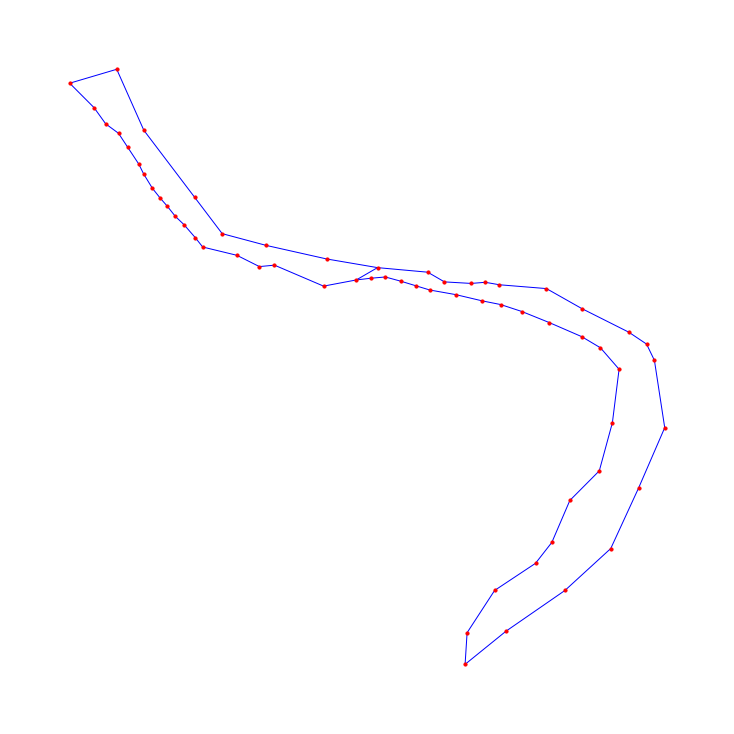

In [ ]:
# Plot the nodes
print(len(G.nodes),'nodes')
plt.figure(figsize=(10, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, node_size=10, node_color="red", edge_color="blue", with_labels=False)
plt.show()

In [ ]:
# Identify degree < or = 2
nodes_deg1 = [node for node, degree in dict(G.degree()).items() if degree == 1]
print(len(nodes_deg1),'nodes with degree 1')
nodes_deg2 = [node for node, degree in dict(G.degree()).items() if degree == 2]
print(len(nodes_deg2),'nodes with degree 2')
nodes_deg3 = [node for node, degree in dict(G.degree()).items() if degree == 3]
print(len(nodes_deg3),'nodes with degree 3')
print(len(G.nodes))

0 nodes with degree 1
60 nodes with degree 2
2 nodes with degree 3
62


In [ ]:
# remove all nodes with deg < or = 2
G_collapsed = G.copy()
G_collapsed.remove_nodes_from(nodes_deg2)
print(len(G_collapsed.nodes),'nodes remaining')

512 nodes remaining


In [ ]:
# Make a copy of the graph for manipulation
G_collapsed = G.copy()

# Identify nodes with degree ≤ 2
nodes_deg2 = [node for node in G_collapsed.nodes if G_collapsed.degree(node) <= 2]
print(len(nodes_deg2))

for node in nodes_deg2:
    # Get neighbors of the node
    neighbors = list(G_collapsed.neighbors(node))
    
    # Ensure the node has exactly 2 neighbors to collapse
    if len(neighbors) == 2:
        u, v = neighbors
        #print(f'u: {u}; v: {v}')
        

        # Sum attributes of edges (node-u and node-v)
        new_edge_data = {}
        edge_data_u = G_collapsed.get_edge_data(node, u, default={})
        #print('attributes u:', edge_data_u)
        edge_data_v = G_collapsed.get_edge_data(node, v, default={})
        #print('atributes v:', edge_data_v)
            
        # Combine attributes
        new_edge_data['edgelength'] = edge_data_u.get('edgelength') + edge_data_v.get('edgelength')
        new_edge_data['slope'] = (edge_data_u.get('slope')*edge_data_u.get('edgelength') + edge_data_v.get('slope')*edge_data_v.get('edgelength'))/new_edge_data['edgelength']
        new_edge_data['Build5m'] = edge_data_u.get('Build5m') + edge_data_v.get('Build5m')
        new_edge_data['Maintain5m'] = edge_data_u.get('Maintain5m') + edge_data_v.get('Maintain5m')
            
        #print('new_edge_data:', new_edge_data)
            
        # Add the new edge with combined attributes
        G_collapsed.add_edge(u, v, **new_edge_data)
    
    # Remove the node after processing
    G_collapsed.remove_node(node)

print(f"Number of nodes in the collapsed graph: {len(G_collapsed)}")


96
Number of nodes in the collapsed graph: 1


In [ ]:
# Iterate through all edges and print attributes for those connected by nodes with degree > 2
print("Edge attributes for edges connected to nodes with degree > 2:")
for u, v, data in G_collapsed.edges(data=True):
     #if G.degree(u) > 2 and G.degree(v) > 2:
        print(f"Edge ({u}, {v}): {data}")

Edge attributes for edges connected to nodes with degree > 2:
Edge ((-13709.983099999838, 143933.88749999925), (-13699.401100000367, 143982.4838999994)): {'edgelength': 49.735186909911846, 'slope': 6.615034956959874, 'Build5m': 240258.55257617813, 'Maintain5m': 93422.57509157842}
Edge ((-13709.983099999838, 143933.88749999925), (-13786.905700000003, 143855.29450000077)): {'edgelength': 111.65962307209116, 'slope': 15.999772953284282, 'Maintain5m': 209741.43597861606, 'Build5m': 539400.3941132429}
Edge ((-13709.983099999838, 143933.88749999925), (-13385.169599999674, 143726.66530000046)): {'edgelength': 447.34031531927275, 'slope': 37.00952284070535, 'Maintain5m': 715418.8468876218, 'Build5m': 1749101.7048801302}
Edge ((-14578.566399999894, 144321.29549999908), (-14282.127399999648, 144346.61950000003)): {'edgelength': 391.34154491621535, 'slope': 29.73166500239874, 'Maintain5m': 551924.6907261942, 'Build5m': 1286252.3186374723}
Edge ((-14578.566399999894, 144321.29549999908), (-14681.5

In [ ]:
def calculate_total_attributes(G, attribute):
    return sum(data.get(attribute, 0) for u, v, data in G.edges(data=True))

original_total_length = calculate_total_attributes(G, 'edgelength')
collapsed_total_length = calculate_total_attributes(G_collapsed, 'edgelength')

print("Original total edgelength:", original_total_length)
print("Collapsed total edgelength:", collapsed_total_length)

Original total edgelength: 273932.65831828205
Collapsed total edgelength: 190066.94278149607


423


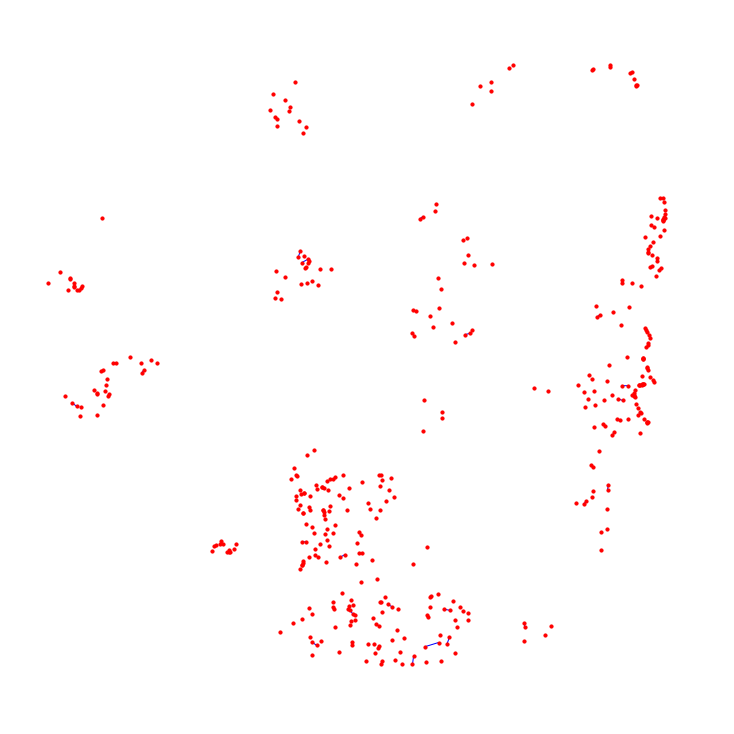

423

In [ ]:
# Plot the graph with fewer nodes
print(len(G.nodes))
plt.figure(figsize=(10, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, node_size=10, node_color="red", edge_color="blue", with_labels=False)
plt.show()
len(G.nodes)

In [ ]:
from shapely.ops import nearest_points
import numpy as np

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
# Extract vertices and edges with attributes for big graph data
list_graphdata = []

for k, df in enumerate(nonsingle_components_B_dfs):
    vertices, edges, edge_attributes = extract_boundaries_with_attributes(df)

    graphdata_B = [vertices, edges, edge_attributes]
    # Append the results to the list
    list_graphdata.append(graphdata)

    print(f'Big roads Component {k+1}')
    print(len(vertices),'vertices')
    print(len(edges), 'exterior edges')
    print(len(edge_attributes), 'edge_attributes')
    print('-------------------')
    if k==0: break

Big roads Component 1
56 vertices
71 exterior edges
71 edge_attributes
-------------------


In [ ]:
from shapely.ops import nearest_points
import numpy as np

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
# Create the bigroads graph
Gbig = nx.Graph()

# Add vertices to the graph
for vertex in big_vertices:
    Gbig.add_node(vertex)

# Add edges with attributes to the graph
for edge, attr in zip(big_exterior_edges, big_edge_attributes):
    u, v = edge
    Gbig.add_edge(u, v, **attr)

# Remove nodes that are not connected by any edges
nodes_to_remove = [node for node in Gbig.nodes if len(list(Gbig.neighbors(node))) == 0]
Gbig.remove_nodes_from(nodes_to_remove)
print(len(nodes_to_remove), 'nodes removed')

print(f"Number of vertices: {len(Gbig.nodes)}")
print(f"Number of edges: {len(Gbig.edges)}")

0 nodes removed
Number of vertices: 10483
Number of edges: 11341


In [ ]:
# old function extract boundaries but without attributes
def extract_boundaries(stands):
    vertices = []
    exterior_edges = []
    interior_edges = []

    for idx, feature in stands.iterrows():
        geometry = feature.geometry
        
        if geometry.geom_type == 'MultiPolygon':
            for poly in geometry:
                # Exterior boundary
                exterior_coords = list(poly.exterior.coords)
                vertices.extend(exterior_coords)
                exterior_edges.extend([(exterior_coords[i], exterior_coords[i+1]) for i in range(len(exterior_coords) - 1)])
                
                # Interior boundaries
                for interior in poly.interiors:
                    interior_coords = list(interior.coords)
                    vertices.extend(interior_coords)
                    interior_edges.extend([(interior_coords[i], interior_coords[i+1]) for i in range(len(interior_coords) - 1)])
        
        elif geometry.geom_type == 'Polygon':
            # Exterior boundary
            exterior_coords = list(geometry.exterior.coords)
            vertices.extend(exterior_coords)
            exterior_edges.extend([(exterior_coords[i], exterior_coords[i+1]) for i in range(len(exterior_coords) - 1)])
            
            # Interior boundaries
            for interior in geometry.interiors:
                interior_coords = list(interior.coords)
                vertices.extend(interior_coords)
                interior_edges.extend([(interior_coords[i], interior_coords[i+1]) for i in range(len(interior_coords) - 1)])
    
    # Remove duplicate vertices
    vertices = list(set(vertices))

    return vertices, exterior_edges, interior_edges

In [ ]:
from shapely.geometry import Point, LineString

def save_graph_to_shapefiles(vertices, edges, edge_attributes, output_path_points, output_path_lines):
    # Convert vertices to Point geometries for nodes
    nodes_gdf = gpd.GeoDataFrame(geometry=[Point(v) for v in vertices])
    nodes_gdf['node_id'] = range(len(vertices))  # Optional: Unique ID for each node

    # Convert edges to LineString geometries directly
    lines = [LineString([u, v]) for (u, v) in edges]  # Here `u` and `v` are coordinates, not indices
    edges_gdf = gpd.GeoDataFrame(geometry=lines)
    
    # Add edge attributes to GeoDataFrame
    edges_gdf = edges_gdf.assign(**{k: [attr[k] for attr in edge_attributes] for k in edge_attributes[0]})

    # Save to shapefiles
    nodes_gdf.to_file(output_path_points, driver="ESRI Shapefile")
    edges_gdf.to_file(output_path_lines, driver="ESRI Shapefile")


In [ ]:
save_graph_to_shapefiles(vertices, exterior_edges, edge_attributes, "points.shp", "lines.shp")

In [ ]:
from shapely.ops import nearest_points

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
merge_close_nodes(vertices, exterior_edges, distance_threshold=10)

AttributeError: 'list' object has no attribute 'sindex'

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString

def save_graph_to_shapefiles(vertices, edges, edge_attributes, output_path_points, output_path_lines):
    # Convert nodes to points with GeoDataFrame
    nodes_gdf = gpd.GeoDataFrame(geometry=[Point(v) for v in vertices])
    nodes_gdf['node_id'] = range(len(vertices))  # Optional: Unique ID for each node

    # Convert edges to lines with GeoDataFrame
    lines = [LineString([vertices[u], vertices[v]]) for (u, v) in edges]
    edges_gdf = gpd.GeoDataFrame(geometry=lines)
    
    # Add edge attributes to GeoDataFrame
    edges_gdf = edges_gdf.assign(**{k: [attr[k] for attr in edge_attributes] for k in edge_attributes[0]})

    # Save to shapefiles
    nodes_gdf.to_file(output_path_points, driver="ESRI Shapefile")
    edges_gdf.to_file(output_path_lines, driver="ESRI Shapefile")
